In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


### Данный проект решает задачу бинарной классификации.
### Нужно предсказать, к какому типу относится транзакция - мошенническая она ли нет.

#### Данные в датасете **transaction**:
<span style="font-size: 18px;">
    
- TransactionDT - дельта времени от заданного эталонного значения времени (не актуального значения) 
- TransactionAMT - транзакционный платёж в USD
- ProductCD - продуктовый код, продукт каждой транзакции
- card1 - card6 - информация платёжной карты, такая как: тип карты, категория, банк выпуска, страна и т.д.
- addr - адрес
- dist - расстояние
- P_ and (R_) emaildomain: домены покупателя и получателя
- C1-C14 - подсчёт, например сколько адресов связано с платёжной картой и т.д. Фактический смысл скрыт
- D1-D15 - дельта времени, количество дней между предыдущей транзакцией, и т.д.
- M1 - M9 -совпадение, например имена на карте и адресе и т.д.
- Vxxx - Vesta разработала богатые функции, включая ранжирование, подсчёт и другие отношения между сущностями
</span>

<span style="font-size:18px;">
Категориальные признаки:

- ProductCD
- card1-card6
- addr1, addr2
- P_emaildomain
- R_email_domain
- M1 - M9
</span>

#### Данные в датасете **Identity**
<span style="font-size:18px;">
Переменные в этой таблице - идентификационные данные:
    
- информация о сетевом соединении (IP, ISP, прокси и т.д.)
- цифровая подпись (UA/браузер/ОС/версия и т.д.), связанные с транзакциями.
Их собирает система защиты от мошенничества Vesta и партнеры цифровой безопасности.
(Имена полей скрыты, и пояснения значений полей не будет в целях защиты конфиденциальности и их договорного соглашения)
</span>

<span style="font-size:18px;">
Категориальные признаки:
    
- DeviceType
- DeviceInfo
- id_12 - id_38
</span>

### Посмотрим, что из себя представляют данные

In [2]:
train_identity_data = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')

In [3]:
train_identity_data.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,...,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,...,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [4]:
print('train_identity_data shape: ', train_identity_data.shape)

train_identity_data shape:  (144233, 41)


In [5]:
train_transaction_data = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')

In [6]:
train_transaction_data.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print('train transaction data shape: ', train_transaction_data.shape)

train transaction data shape:  (590540, 394)


In [8]:
train_identity_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  144233 non-null  int64  
 1   id_01          144233 non-null  float64
 2   id_02          140872 non-null  float64
 3   id_03          66324 non-null   float64
 4   id_04          66324 non-null   float64
 5   id_05          136865 non-null  float64
 6   id_06          136865 non-null  float64
 7   id_07          5155 non-null    float64
 8   id_08          5155 non-null    float64
 9   id_09          74926 non-null   float64
 10  id_10          74926 non-null   float64
 11  id_11          140978 non-null  float64
 12  id_12          144233 non-null  object 
 13  id_13          127320 non-null  float64
 14  id_14          80044 non-null   float64
 15  id_15          140985 non-null  object 
 16  id_16          129340 non-null  object 
 17  id_17          139369 non-nul

Посмотрим какой объём оперативной памяти занимают датасеты:

In [9]:
train_id_GB = train_identity_data.memory_usage(deep=True).sum()/1024**3
train_transaction_GB = train_transaction_data.memory_usage(deep=True).sum()/1024**3

print(f'train_identity dataframe: {train_id_GB:.2f} GB of memory')
print(f'train_transaction dataframe: {train_transaction_GB:.2f} GB of memory')

train_identity dataframe: 0.15 GB of memory
train_transaction dataframe: 2.05 GB of memory


Видим, что датафреймы занимают достаточно большой объём оперативной памяти, следовательно на обработку каждого датафрейма, особенно **train_transaction** будет затрачено большое кол-во ресурсов и довольно длительное время. 

Исходя из этого необходимо уменьшить занимаемый ими объём памяти. Сделаем это при помощи способа с изменением типов переменных

Возьмём все значения типа ```int``` и преобразуем их в ```uint``` типы, т.к. хранение только положительных значений позволит нам уменьшить объём занимаемой памяти

In [10]:
def memory_usage(pandas_object):
    if isinstance(pandas_object, pd.DataFrame):
        usage_b = pandas_object.memory_usage(deep=True).sum()
    else:
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert to mb
    return '{:03.2f} MB'.format(usage_mb)
gl_int = train_identity_data.select_dtypes(include=['int'])
converted_int = gl_int.apply(pd.to_numeric, downcast='unsigned')
print('downcast subtypes "int" to "uint"')
print('memory usage before: ', memory_usage(gl_int))
print('memory usage after:  ', memory_usage(converted_int))

downcast subtypes "int" to "uint"
memory usage before:  1.10 MB
memory usage after:   0.55 MB


Проделаем ту же операцию для ```float``` переменных:

In [11]:
gl_float = train_identity_data.select_dtypes(include=['float'])
converted_float = gl_float.apply(pd.to_numeric, downcast='float')
print('downcast subtypes of "float" to "float"')
print('memory usage before: ', memory_usage(gl_float))
print('memory usage after:  ', memory_usage(converted_float))

downcast subtypes of "float" to "float"
memory usage before:  25.31 MB
memory usage after:   12.65 MB


Теперь создадим копию нашего датасета ```train_identity``` и заменим текущие числовые значения на преобразованные:

In [12]:
optimized_train_identity = train_identity_data.copy()
optimized_train_identity[converted_int.columns] = converted_int
optimized_train_identity[converted_float.columns] = converted_float
print('===== Memory usage of train_identity =====')
print('before optimization: ', memory_usage(train_identity_data))
print('after optimization: ', memory_usage(optimized_train_identity))

===== Memory usage of train_identity =====
before optimization:  157.63 MB
after optimization:  144.43 MB


In [13]:
opt_in_prct = 100 - (144.43 * 100 / 157.63)
print(f'optimization memory of train_identity: {opt_in_prct} %')

optimization memory of train_identity: 8.374040474528954 %


Видим, что для датасета ```train_identity``` преобразование подтипов ```int``` и ```float``` уменьшает объём памяти на ```8.37 %```

Теперь проделаем то же самое для датасета ```train_transaction```

In [14]:
int_train_tr = train_transaction_data.select_dtypes(include=['int'])
converted_int_train_tr = int_train_tr.apply(pd.to_numeric, downcast='unsigned')
print('downcast subtypes "int" to "uint" of train_transaction')
print('memory usage before: ', memory_usage(int_train_tr))
print('memory usage after: ', memory_usage(converted_int_train_tr))

downcast subtypes "int" to "uint" of train_transaction
memory usage before:  18.02 MB
memory usage after:  6.20 MB


In [15]:
float_train_tr = train_transaction_data.select_dtypes(include=['float'])
converted_float_train_tr = float_train_tr.apply(pd.to_numeric, downcast='float')
print('downcast subtypes "float" to "float" of train_transaction')
print('memory usage before: ', memory_usage(float_train_tr))
print('memory usage after: ', memory_usage(converted_float_train_tr))

downcast subtypes "float" to "float" of train_transaction
memory usage before:  1694.05 MB
memory usage after:  847.03 MB


In [16]:
optimized_train_tr = train_transaction_data.copy()
optimized_train_tr[converted_int_train_tr.columns] = converted_int_train_tr
optimized_train_tr[converted_float_train_tr.columns] = converted_float_train_tr
print('===== Memory usage of train_transaction =====')
print('before optimization: ', memory_usage(train_transaction_data))
print('after optimization: ', memory_usage(optimized_train_tr))

===== Memory usage of train_transaction =====
before optimization:  2100.70 MB
after optimization:  1241.85 MB


In [17]:
train_tr_opt_prct = 100 - (1241.85 * 100 / 2100.7)
print(f'optimization memory of train_transaction: {train_tr_opt_prct} %')

optimization memory of train_transaction: 40.883991050602184 %


Для датасета ```train_transaction``` преобразование чиловых подтипов уменьшает объём занимаемой памяти на ```40.88 %```

Уменьшение объёма занимаемой памяти достигается также преобразованием переменных типа ```object``` в тип ```category```.

Также согласно исследованиям, считается, что преобразование в тип ```category``` следует проводить у столбцов с менее чем ```50 %``` уникальными значениями, иначе после преобразования объём занимаемой памяти наоборот увеличится.

Выполним соотвествующее преобразование для датасета ```train_identity```

In [18]:
train_id_obj = optimized_train_identity.select_dtypes(include=['object']).copy()

def obj_to_cat(current_df_obj):
    converted_df_obj=pd.DataFrame()
    for col in current_df_obj.columns:
        num_unique_values = len(current_df_obj[col].unique())
        num_total_values = len(current_df_obj[col])
        if num_unique_values / num_total_values < 0.5:
            converted_df_obj.loc[:, col] = current_df_obj[col].astype('category')
        else:
            converted_df_obj.loc[:, col] = current_df_obj[col]
    return converted_df_obj

train_id_converted_obj = obj_to_cat(train_id_obj)
print('downcast "object" to "category" of train_identity')
print('memory usage before: ', memory_usage(train_id_obj))
print('memory usage after: ', memory_usage(train_id_converted_obj))

downcast "object" to "category" of train_identity
memory usage before:  131.22 MB
memory usage after:  2.99 MB


In [19]:
print('==== Memory usage of train_identity =====')
print('before optimization: ', memory_usage(train_identity_data))
optimized_train_identity[train_id_converted_obj.columns] = train_id_converted_obj
print('after optimization: ', memory_usage(optimized_train_identity))

==== Memory usage of train_identity =====
before optimization:  157.63 MB
after optimization:  16.19 MB


In [20]:
opt_tr_id_prct = 100 - (16.19 * 100 / 157.63)
print(f'optimization memory of train identity: {opt_tr_id_prct} %')

optimization memory of train identity: 89.7291124785891 %


Видим, что после всех оптимизаций объём занимаемой памяти у датасета
```train_identity``` уменьшился практически на 90 %!

Проделаем преобразование типов ```object``` в ```category``` для датасета ```train_transaction```

In [21]:
train_tr_obj = optimized_train_tr.select_dtypes(include=['object']).copy()
train_tr_converted_obj = obj_to_cat(train_tr_obj)
print('downcasr "object" to "category" of train_transaction')
print('memory usage before: ', memory_usage(train_tr_obj))
print('memory usage after: ', memory_usage(train_tr_converted_obj))

downcasr "object" to "category" of train_transaction
memory usage before:  388.63 MB
memory usage after:  7.90 MB


In [22]:
print('==== Mermory usage of train_transaction ====')
print('before optimization: ', memory_usage(train_transaction_data))
optimized_train_tr[train_tr_converted_obj.columns] = train_tr_converted_obj
print('after optimization: ', memory_usage(optimized_train_tr))

==== Mermory usage of train_transaction ====
before optimization:  2100.70 MB
after optimization:  861.12 MB


In [23]:
opt_tr_tr_prct = 100 - (861.12 * 100 / 2100.70)
print(f'optimization memory of train transaction: {opt_tr_tr_prct} %')

optimization memory of train transaction: 59.00794973104203 %


После всех оптимизаций объём занимаемой памяти датасета ```train_transaction``` уменьшился на ```59 %```

In [24]:
optimized_train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   TransactionID  144233 non-null  uint32  
 1   id_01          144233 non-null  float32 
 2   id_02          140872 non-null  float32 
 3   id_03          66324 non-null   float32 
 4   id_04          66324 non-null   float32 
 5   id_05          136865 non-null  float32 
 6   id_06          136865 non-null  float32 
 7   id_07          5155 non-null    float32 
 8   id_08          5155 non-null    float32 
 9   id_09          74926 non-null   float32 
 10  id_10          74926 non-null   float32 
 11  id_11          140978 non-null  float32 
 12  id_12          144233 non-null  category
 13  id_13          127320 non-null  float32 
 14  id_14          80044 non-null   float32 
 15  id_15          140985 non-null  category
 16  id_16          129340 non-null  category
 17  id_17     

In [25]:
optimized_train_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: category(14), float32(376), uint16(1), uint32(2), uint8(1)
memory usage: 861.1 MB


Объединим датасеты ```train_identity``` и ```train_transaction``` в один датасет:

In [26]:
train = optimized_train_tr.merge(optimized_train_identity, on=['TransactionID'], how='left')
print(f'size of train: {train.shape}')

size of train: (590540, 434)


In [27]:
train.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


Т.к. мы объединили датасеты ```train_identity``` и ```train_transaction```, удалим их для того, чтобы освободить память

In [28]:
del optimized_train_identity
del optimized_train_tr
gc.collect

<function gc.collect(generation=2)>

Проверим текущий объём памяти датасета ```train```:

In [29]:
print('memory usage of train: ', memory_usage(train))

memory usage of train:  924.43 MB


Посмотрим на кол-во пропущенных значений в датасете ```train```

In [30]:
total_null = train.isnull().sum().to_frame()
prct_null = train.isnull().sum()/train.isnull().count()*100

pd.concat([total_null, prct_null], axis=1, keys=['Total misssing values', 'Percent']).transpose()

,,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
Total misssing values,0,0.0,0.0,0.0,0.0,0.0,0.0,8933.000000,1565.000000,1577.000000,4259.000000,...,450258.000000,512954.000000,517251.000000,512735.000000,449555.000000,449555.000000,449555.000000,449555.000000,449730.000000,471874.00000
Percent,0,0.0,0.0,0.0,0.0,0.0,0.0,1.512683,0.265012,0.267044,0.721204,...,76.245132,86.861855,87.589494,86.824771,76.126088,76.126088,76.126088,76.126088,76.155722,79.90551


Посмотрим на распределение целевых меток ```isFraud```

In [31]:
isFraud_count = train['isFraud'].value_counts()
isFraud_prct = train['isFraud'].value_counts()/len(train)

pd.concat([isFraud_count, isFraud_prct], axis=1, keys=['Count', 'Percent'])

,Count,Percent
isFraud,,
0,569877,0.96501
1,20663,0.03499


In [32]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_value_counts(feature, title, df):
    ax = df[feature].value_counts().plot(kind='bar',
                                        figsize=(7,5),
                                        xlabel=title,
                                        ylabel='count',
                                        color=colors)
    ax.set_title(f'Percentage of {title}')
    counts = df[feature].value_counts()/len(df)
    
    rects = ax.patches
    labels_arr = ['{0:.2f}%'.format(count*100) for count in counts]
    
    if (len(labels_arr) > 2):
        plt.xticks(rotation=0, size=8)
        
    for rect, label in zip(rects, labels_arr):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha='center'
        )
        
    plt.show()

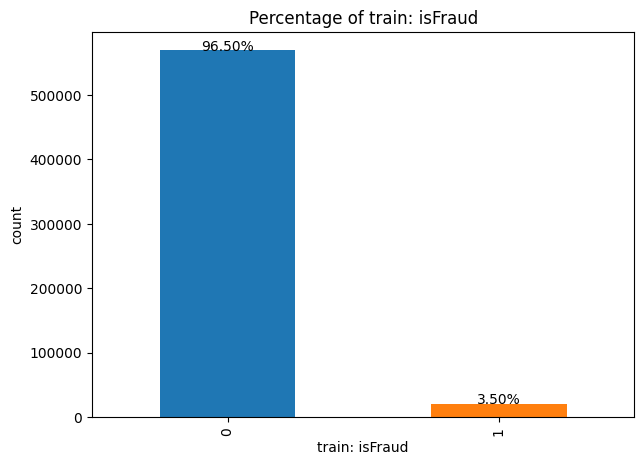

In [33]:
plot_value_counts('isFraud', 'train: isFraud', df=train)

Видим, что данные не сбалансированы.

```96,5 %``` транзакций - валидны

```3,5 %``` транзакций - мошеннические

Подумаем о решении вопроса дисбаланса в данных. Исследуем другие признаки

Распределение ```Card 4``` (компания карты)

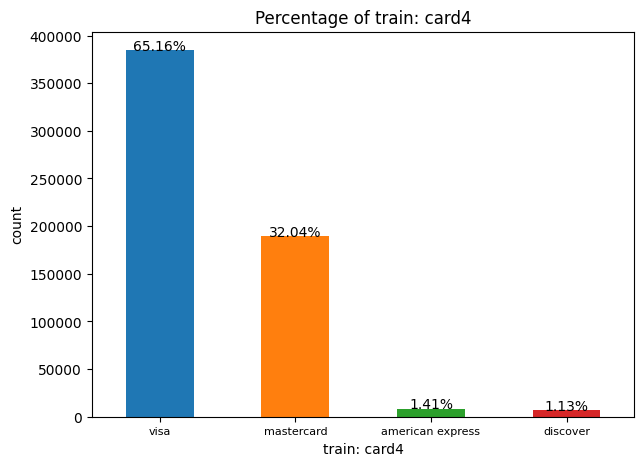

In [34]:
plot_value_counts('card4', 'train: card4', df=train)

Видим, что:
- ```65.16 %``` - карт компании 'visa'
- ```32.04 %``` - 'mastercard'
- ```1.41 %```  - 'american express'
- ```1.13 %```  - 'discover'

Распределение ```Card 6``` - тип карты

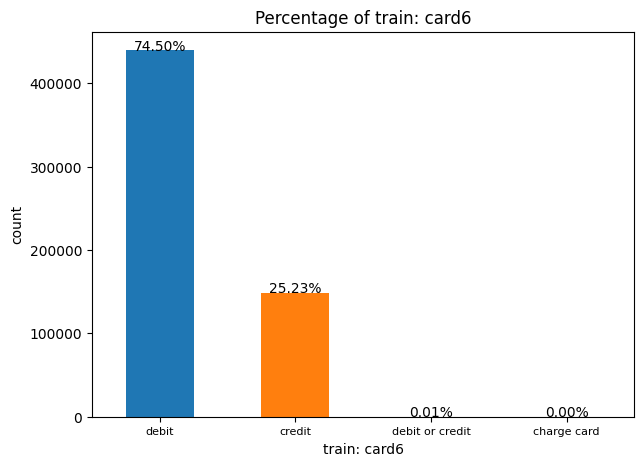

In [35]:
plot_value_counts('card6', 'train: card6', df=train)

Боьшая часть транзакций в данном датасете произведена дебетовыми картами - ```74.5 %```, ```25.23 %``` - кредитными картами. Транзакций с ```charge``` карт нет

Распределение транзакций по ```DeviceType```

DeviceType
desktop    85165
mobile     55645
Name: TransactionDT, dtype: int64


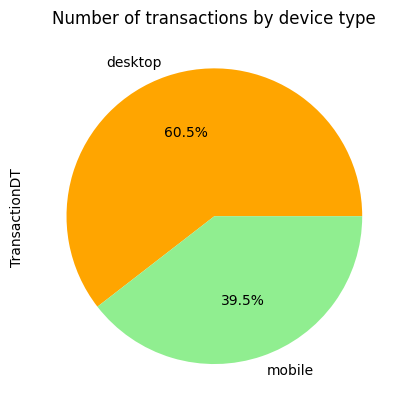

In [36]:
device_type_df = train.groupby(by='DeviceType').TransactionDT.count()
device_type_df.plot(kind='pie', 
                    colors=['orange', 'lightgreen'],
                    autopct='%1.1f%%')
plt.title('Number of transactions by device type')
print(device_type_df)

Большинство транзакций было выполнено с компьютера - ```60.5 %```.

С мобильных устройств - ```39.5 %``` транзакций

Посмотрим на процент мошеннических транзакций в разрезе компаний, выпустивших карты

In [37]:
def isFraud_by_feature(feature, df, title):
    sns.barplot(x=feature, y='isFraud', data=df)
    plt.xlabel(feature)
    plt.ylabel('isFraud')
    plt.title('Fraudulent Transactions by {}'.format(title))
    plt.show()

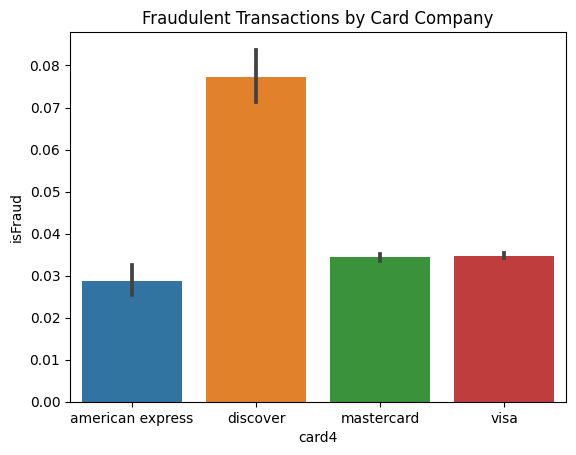

In [38]:
isFraud_by_feature('card4', df=train, title='Card Company')

Видим, что большинство мошеннических транзакций произведено с карты ```discover```

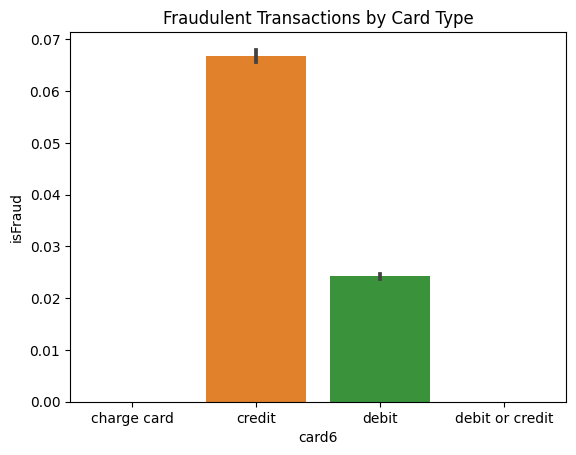

In [39]:
isFraud_by_feature('card6', df=train, title='Card Type')

Несмотря на то, что кредитные карты занимают ```25.23 %``` от всего объёма данных, с них произведена большая часть мошеннических транзакций

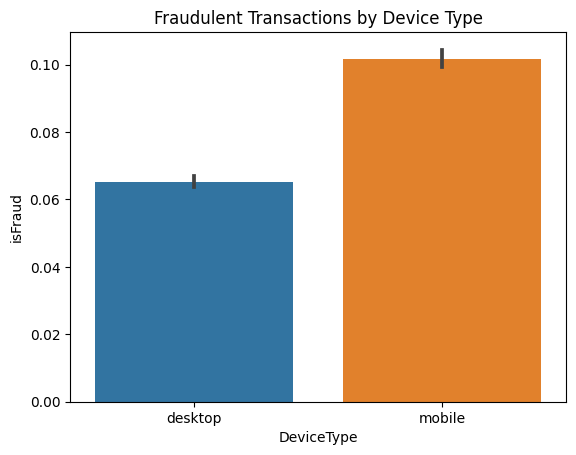

In [40]:
isFraud_by_feature('DeviceType', df=train, title='Device Type')

Большинство мошеннических операций было произведено с мобильных устройств

### Отделим данные обучения (категориальные и числовые признаки) от целевых меток

Сохраним целевые переменные в переменную ```y_train```

In [41]:
y_train = train['isFraud']

Создадим списки из числовых и категориальных признаков:

In [42]:
cat_features = train.select_dtypes(include=['category']).columns
num_features = [x for x in train.columns.values[2:] 
                if x not in cat_features]
print('len cat_features: ', len(cat_features))
print('len num_features: ', len(num_features))

len cat_features:  31
len num_features:  401
